In [1]:
!pip install langdetect
!pip install googletrans==3.1.0a0
!pip install unidecode==1.3.6
!pip install contractions

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Not uninstalling idna at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'idna'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import unidecode

from langdetect import detect
from googletrans import Translator

import nltk

#Librerias Osiris
import nltk
import contractions
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords


import unicodedata

In [3]:
translator = Translator()

In [4]:
# Loading the dataset
df = pd.read_csv('data/tweet_NLP_Data.csv')

# EDA

In [5]:
# Overall description of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79592 entries, 0 to 79591
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    79496 non-null  object
 1   label   79592 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
print('Dataset tweets: ',len(df),'\nDataset shape: ',df.shape)

Dataset tweets:  79592 
Dataset shape:  (79592, 2)


In [7]:
# Identifying the target portions
df['label'].value_counts()

HOTD    42094
ROP     37498
Name: label, dtype: int64

In [8]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

([<matplotlib.patches.Wedge at 0x7ff8705d96d0>,
 [Text(-0.1195662960655121, 1.314573657443802, 'HOTD'),
  Text(0.11956629606551136, -1.314573657443802, 'ROP')],
 [Text(-0.0652179796720975, 0.7170401767875283, '52.9%\n(42094)'),
  Text(0.06521797967209711, -0.7170401767875283, '47.1%\n(37498)')])

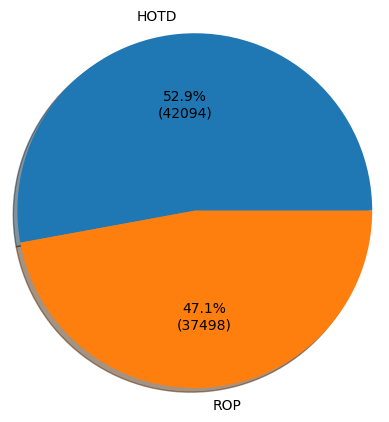

In [9]:
values = [df['label'].value_counts()[0],df['label'].value_counts()[1]]
labels = ['HOTD','ROP']

plt.pie(values,labels=labels,radius=1.2,autopct=autopct_format(values), shadow=True)

HOTD    0.528872
ROP     0.471128
Name: label, dtype: float64


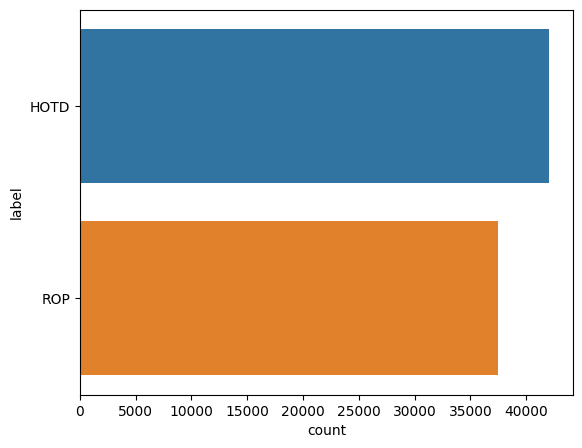

In [10]:
stats_target = df['label'].value_counts(normalize=True)
print(stats_target)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=df,y='label')
plt.show()

# Data Preprocessing

## Missing Values

In [11]:
# Nall values represent the 0.1% of the dataset
df.isna()

,text,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
79587,False,False
79588,False,False
79589,False,False
79590,False,False


In [12]:
#Create a mask for the rows containing atleast one NaN value
mask = df.isna().any(axis=1)

#Pass the mask to df.loc[] to obtain the required rows
index_rows_with_null_values = df.loc[mask].index.tolist()

In [13]:
# Removing all rows that contains NaN values
df.drop(index_rows_with_null_values,axis=0,inplace=True)

# Reseting the index
df.reset_index(drop=True,inplace=True)

# Verifying we alredy have removed all NaN values from the dataset
df.isna()

,text,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
79491,False,False
79492,False,False
79493,False,False
79494,False,False


## Text Cleaning

### Normalization Techniques

In [14]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
class PreProcessor:
    
    def __init__(self, df,regex_dict = None):
        
        # creating classes
        # stem
        self.sb = nltk.stem.SnowballStemmer('english')

        # DataFrame
        self.pdf = df
        self.pdf = self.pdf.astype(str)
        
        # lemmatize
        self.lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
        
        # translate
        self.translator = Translator()
        
        # declare a default regex dict
        self.default_regex_dict = {'goo[o]*d': 'good', 'tbh': 'to be honest', 'asap':'as soon as possible', 'btw':'by the way', 
                                   'idk':"i don't know", 'bc':'because', 'yeah':'yes', ':)':'smile', '=(': 'sad', ':(':'sad', '<3':'love',
                                   'b4':'before', 'otw':'on the way', 'yay': 'yes', 'w/': 'with', 'lol': 'funny', '=]':'smile',
                                   'gpi': 'gracias por invitar', 'gf': 'girlfriend', 'ugh': 'angry', 'rt': 'retweet', 'g2': 'generation two',
                                  'yummmmm': 'delicious', '<3': 'love', 'gonna': 'going to',
                                  '[bB]ffs': 'best friends', "[tT]oday's episode": "the episode of today", 'lmaooo': 'funny',
                                  'bee4': 'before'}
        
        # List that saves all # in the text
        self.hash_list = []

        # if no regex_dict defined by user, then use 
        # one by default. Else, concat two regex dicts
        if regex_dict:            
            self.regex_dict = {**regex_dict, **default_regex_dict}
            
        else:
            self.regex_dict = self.default_regex_dict

    def getHashtags(self,text):

        hashtags = re.findall('[#]\w+',text)
        self.hash_list.append(hashtags)

        return self.hash_list

    def languageDetection(self,text):
        # Return the langauge of the text
        return detect(text)

    def languageChanging(self,text):
        # Change the language if it is spanish, otherwise it removes it from the dataframe
        try:
            if text == ' ' or text == '' or len(text) <= 6:
                idx = self.pdf[self.pdf['clean_tweet'] == text].index
                self.pdf.drop(idx, axis=0, inplace=True)
            else:
                language = self.languageDetection(text)

                if language == 'en':
                    return text
                elif language == 'es':
                    translation = translator.translate(text, src=language)
                    return translation.text
                else:
                    idx = self.pdf[self.pdf['clean_tweet'] == text].index
                    self.pdf.drop(idx, axis=0, inplace=True)
        except:
            print(text)
            idx = self.pdf[self.pdf['clean_tweet'] == text].index
            self.pdf.drop(idx, axis=0, inplace=True)

    def equilibrium(self):
        # Make a balance 
        df_hotd = self.pdf[self.pdf["label"]=='HOTD']
        df_rop= self.pdf[self.pdf["label"]=='ROP']

        if len(df_hotd) < len(df_rop):
            df_rop_downsampled = df_rop.sample(df_hotd.shape[0])
            df_balenced = pd.concat([df_hotd, df_rop_downsampled])
            self.pdf = df_balenced
        else:
            df_hotd_downsampled = df_hotd.sample(df_rop.shape[0])
            df_balenced = pd.concat([df_rop, df_hotd_downsampled])
            self.pdf = df_balenced

        return self.pdf
            
    def removeNoise(self):
        
        # to lower case
        self.pdf["clean_tweet"] = self.pdf.text.apply(lambda x: x.lower())

        # Get all hashtags
        self.pdf.text.apply(self.getHashtags)
                
        self.pdf["clean_tweet"] = self.pdf.clean_tweet.apply(lambda x:' '.join(re.sub("(@[^\s]+)|(#[A-Za-z0-9]+)|([\s]+)|([-.,:_;])|(www?:\/\/.*[\r\n]*)|(https?:\/\/.*[\r\n]*)|(rt)| (\W+)", " ", x).split()).replace('"',''))
        
        # remove accented characters from string
        # e.g. canción --> cancion
        self.pdf["clean_tweet"] = self.pdf.clean_tweet.apply(lambda x: unidecode.unidecode(x))
        
        # remove html tags 
        self.pdf["clean_tweet"] = self.pdf.clean_tweet.str.replace(r'<[^<>]*>', '', regex=True)

        # remove white spaces at the begining and at 
        # the end of a string
        self.pdf['clean_tweet'] = self.pdf.clean_tweet.apply(lambda x: x.lstrip(' '))
        self.pdf['clean_tweet'] = self.pdf.clean_tweet.apply(lambda x: x.rstrip(' '))
        
        # normalize string
        # normalize accented charcaters and other strange characters
        # NFKD if there are accented characters (????
        self.pdf["clean_tweet"] = self.pdf.clean_tweet.apply(lambda x: unicodedata.normalize('NFKC', x).encode('ASCII', 'ignore').decode("utf-8"))
        
        # Language detection
        self.pdf["clean_tweet"] = self.pdf.clean_tweet.apply(self.languageChanging)

        # Reseting the index of the DataFrame
        self.pdf.reset_index(drop=True,inplace=True)

        # Balancing the dataframe labels
        self.pdf = self.equilibrium()

        return self.pdf

    def textNormalization(self):

        # remove noise first
        self.pdf = self.removeNoise()

        # expand contractions
        # e.g. don't --> do not
        self.pdf['text_normalization'] = self.pdf.clean_tweet.apply(lambda x: contractions.fix(x))
         
        # Normalize words
        self.pdf['text_normalization'] = self.pdf.text_normalization.replace(self.regex_dict)
                
        # get English stopwords    
        stop_words = stopwords.words('english') ##descargar stopwords spanish
        stop_words.extend(['that','thats','oh', 'h', 'also', 'aww', 'mr', 'r', 'what', 'opt', 'etc', 'hey', 'within', 
                            'foi', 'yeah', 'www', 'wa', 'em', 'am', 'i', 'me', 'dialmformurderjpg' ])

        #stop_words_spanish = stopwords.words('spanish')
        #stop_words_spanish.extend(['ma', 'e', 'pa' 'u'])

        stopwords_dict = Counter(stop_words)
        #stopwords_dict_spa = Counter(stop_words_spanish)
        
        # remove stopwords from string - English
        self.pdf["text_normalization"] = self.pdf.text_normalization.apply(lambda x: ' '.join([word for word in x.split()
                                                                       if word not in stopwords_dict]))

        # remove stopwords from string - Spanish
        #self.pdf["clean_tweet"] = self.pdf.clean_tweet.apply(lambda x: ' '.join([word for word in x.split()
        #                                                              if word not in stopwords_dict_spa]))

        return self.pdf

    def wordTokenize(self):
        
        # string normalized
        #normalized = self.textNormalization(string)
        self.pdf = self.textNormalization()
        
        # Use word_tokenize method to split the string
        # into individual words. By default it returns
        # a list.
        self.pdf["word_tokenize"] = self.pdf.text_normalization.apply(lambda x: nltk.word_tokenize(x))        
        
        # Using isalpha() will help us to only keep
        # items from the alphabet (no punctuation
        # marks). 
        self.pdf["word_tokenize"] = self.pdf.word_tokenize.apply(lambda x: [word for word in x if word.isalpha()])
        
        # Keep only unique elements
        self.pdf["word_tokenize"] = self.pdf.word_tokenize.apply(lambda x: list(set(x)))

        # return list of tokenized words by row
        return self.pdf

    def lemmatizeWords(self):

        # pandas dataframe with strings normalized
        self.pdf = self.textNormalization()
        
        self.pdf = self.wordTokenize()
        
        # lematize word from list of tokenized words
        self.pdf["lemmatize_words"] = self.pdf.word_tokenize.apply(lambda x: [self.lemmatizer.lemmatize(word) for word in x])
        
        return self.pdf

In [19]:
preprocesor = PreProcessor(df)

In [20]:
df1 = preprocesor.lemmatizeWords()
df1

-----------   | | | | | | | | | | | | | | | | |
// // // // // // ...
<> 2021
* * * * * ...


,text,label,clean_tweet,text_normalization,word_tokenize,lemmatize_words
0,@BookstAnna Uncover the truth.\nStream #HOTD t...,HOTD,uncover the truth stream tonight at 9pm on rep...,uncover truth stream tonight 9pm reply,"[reply, truth, stream, tonight, uncover]","[reply, truth, stream, tonight, uncover]"
1,RT @arishatistic: the kiss we deserved\n\n#hot...,HOTD,the kiss we deserved,kiss deserved,"[kiss, deserved]","[kiss, deserved]"
2,RT @caffrey05: Ya quiero que se muera Viserys ...,HOTD,I already want Viserys to die so that the real...,I already want Viserys die real chaos begin ho...,"[real, Viserys, begin, die, I, chaos, like, ho...","[real, Viserys, begin, die, I, chaos, like, ho..."
3,RT @HOTDsource: More of Milly Alcock behind th...,HOTD,more of milly alcock behind the scenes of epis...,milly alcock behind scenes episode 5 adorable,"[episode, adorable, alcock, milly, scenes, beh...","[episode, adorable, alcock, milly, scene, behind]"
4,@mfredericks1x Duty above all. \nStream #HOTD ...,HOTD,duty above all stream tonight at 9pm on reply ...,duty stream tonight 9pm reply,"[duty, tonight, stream, reply]","[duty, tonight, stream, reply]"
...,...,...,...,...,...,...
47064,Amazon’s Delay for ‘The Rings of Power’ Review...,ROP,amazon's delay for 'the rings of power' review...,amazon's delay 'the rings power' reviews prime...,"[pa, initiative, exclusive, filter, trolls, re...","[pa, initiative, exclusive, filter, troll, rev..."
42751,The latest #TheRingsOfPower trailer has us the...,ROP,the latest trailer has us theorizing to the mo...,latest trailer us theorizing moon back! read t...,"[back, thoughts, latest, read, us, theorizing,...","[back, thought, latest, read, u, theorizing, t..."
27427,The Lord of the Rings: The Rings of Power Revi...,ROP,the lord of the rings the rings of power revie...,lord rings rings power review fantastic world ...,"[lord, world, search, power, rings, fantastic,...","[lord, world, search, power, ring, fantastic, ..."
52060,Half way through the first episode of Rings of...,ROP,half way through the first episode of rings of...,half way first episode rings power already lov...,"[loving, aaaahhh, already, half, power, episod...","[loving, aaaahhh, already, half, power, episod..."


### Label Balancing - Verification

([<matplotlib.patches.Wedge at 0x7ff85ea94940>,
 [Text(8.082668874372532e-17, 1.32, 'HOTD'),
  Text(-2.4248006623117594e-16, -1.32, 'ROP')],
 [Text(4.4087284769304716e-17, 0.72, '50.0%\n(26927)'),
  Text(-1.3226185430791412e-16, -0.72, '50.0%\n(26927)')])

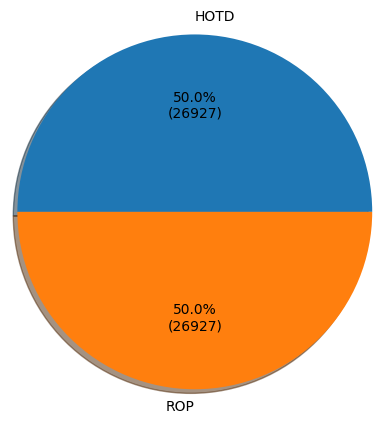

In [21]:
values = [df1['label'].value_counts()[0],df1['label'].value_counts()[1]]
labels = ['HOTD','ROP']

plt.pie(values,labels=labels,radius=1.2,autopct=autopct_format(values), shadow=True)

In [23]:
df1.to_csv('data/tweet_nlp_data_cleaned.csv',index = False)

In [24]:
df = pd.read_csv('data/tweet_nlp_data_cleaned.csv')
df.head(5)

,text,label,clean_tweet,text_normalization,word_tokenize,lemmatize_words
0,@BookstAnna Uncover the truth.\nStream #HOTD t...,HOTD,uncover the truth stream tonight at 9pm on rep...,uncover truth stream tonight 9pm reply,"['reply', 'truth', 'stream', 'tonight', 'uncov...","['reply', 'truth', 'stream', 'tonight', 'uncov..."
1,RT @arishatistic: the kiss we deserved\n\n#hot...,HOTD,the kiss we deserved,kiss deserved,"['kiss', 'deserved']","['kiss', 'deserved']"
2,RT @caffrey05: Ya quiero que se muera Viserys ...,HOTD,I already want Viserys to die so that the real...,I already want Viserys die real chaos begin ho...,"['real', 'Viserys', 'begin', 'die', 'I', 'chao...","['real', 'Viserys', 'begin', 'die', 'I', 'chao..."
3,RT @HOTDsource: More of Milly Alcock behind th...,HOTD,more of milly alcock behind the scenes of epis...,milly alcock behind scenes episode 5 adorable,"['episode', 'adorable', 'alcock', 'milly', 'sc...","['episode', 'adorable', 'alcock', 'milly', 'sc..."
4,@mfredericks1x Duty above all. \nStream #HOTD ...,HOTD,duty above all stream tonight at 9pm on reply ...,duty stream tonight 9pm reply,"['duty', 'tonight', 'stream', 'reply']","['duty', 'tonight', 'stream', 'reply']"


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=00a22f29-a5e3-4429-9c65-3f412ce34eac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>